# Creating a General Purpose Potential for Molecular Crystals - Part 3

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- An initial test GAP model is produced by FPS-selecting sparse points
- PCovCUR sample selection is carried out (to determine the optimal number of training configurations to add into the actualy GAP model
- Hyperparameters are optimised using the test GAP model
- Production GAP model is created

### Import modules, functions, and necessary raw data from parts 1 & 2

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools

import pickle
import numpy as np
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score
from rascal.utils.io import load_json, dump_json


In [2]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999))): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

In [3]:
#Import raw data
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
X_train_fps = np.load('raw_data/X_train_fps.npy')
y_train_fps = np.load('raw_data/y_train_fps.npy')
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)
initial_train_set = np.load('raw_data/initial_train_set_4pc.npy', allow_pickle=True)

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.1.0rc1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Constructing test GAP model

In [4]:
#Redefine hyperparameters and SOAP, with compute_gradients = True
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=True #compute forces now too
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

### Calculate optimal sparse points

In [5]:
hypers["compute_gradients"] = False
hypers["max_radial"] = 6
soap = SphericalInvariants(**hypers)

In [115]:
# Compute reduced (2238) training set feature matrices and sparsify them 
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(initial_train_set[:2238]) #calculating features
nsparse    = {1: 10000, 6: 10000, 7: 10000, 8: 10000} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species')#Filter to sparsify full feature matrix
print("Time taken: ", time()-start, "s")
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  34.191445112228394 s
Sparsifying training set...
Time taken:  356.8876929283142 s


In [116]:
#Saving sparse points
dump_obj('raw_data/X_sparse_1pc_nsparse10000_FPS.json', X_sparse)

In [12]:
#Load FPS-sorted sparse points
X_sparse = load_obj('raw_data/X_sparse_1pc_nsparse10000_FPS.json')

#### Calculate reconstruction error

In [209]:
#Get features of sparse points
sparse_feat = X_sparse.get_features()

In [211]:
#Calculate original features, inverse of sparse features
manager = soap.transform(initial_train_set[:500]) #test on 25 structures
original_features = manager.get_features(soap) # original features

In [212]:
#Get only hydrogen atom features from the initial training set
species = np.array([],dtype=int)
for frm in initial_train_set[:500]:
    species = np.append(species,frm.get_atomic_numbers(),axis=0)

species_feat = {1:[],6:[],7:[],8:[]}
for feat,spe in zip(original_features,species):
    for sp in [1,6,7,8]:
        if spe == sp:
            species_feat[sp].append(feat)
for sp in [1,6,7,8]:
    species_feat[sp] = np.array(species_feat[sp])

In [213]:
jitter = 1e-12
error = {1:[],6:[],7:[],8:[]}
for isp,sp in enumerate([1,6,7,8]):
    print(sp)
    start = isp*10000
    for nsparse in [int(n) for n in np.logspace(2,4,25)]:
        sparse_kernel = np.dot(sparse_feat[start:start+nsparse],sparse_feat[start:start+nsparse].T)
        inverse = np.linalg.inv(sparse_kernel + jitter*np.eye(sparse_kernel.shape[0]))
        weights = np.dot(sparse_feat[start:start+nsparse].T,
                         np.dot(inverse,sparse_feat[start:start+nsparse]))
        feat_repr = np.dot(weights.T,species_feat[sp].T).T
        
        kernel = np.dot(species_feat[sp],species_feat[sp].T)
        repr_kernel = np.dot(feat_repr,feat_repr.T)
        
        error[sp].append(np.std(kernel - repr_kernel))
        print(nsparse,np.round(np.std(kernel - repr_kernel),8))

1
100 0.00075889


KeyboardInterrupt: 

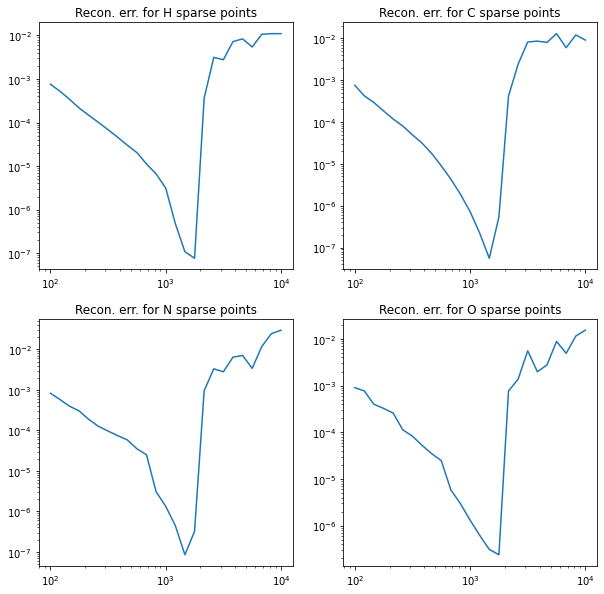

In [124]:
f, p = plt.subplots(2,2,figsize=(10,10))
p0=p[0][0].plot([int(n) for n in np.logspace(2,4,25)], error[1])
p[0][0].set_title('Recon. err. for H sparse points')
p[0][0].set_xscale('log')
p[0][0].set_yscale('log')
p0=p[0][1].plot([int(n) for n in np.logspace(2,4,25)], error[6])
p[0][1].set_title('Recon. err. for C sparse points')
p[0][1].set_xscale('log')
p[0][1].set_yscale('log')
p0=p[1][0].plot([int(n) for n in np.logspace(2,4,25)], error[7])
p[1][0].set_title('Recon. err. for N sparse points')
p[1][0].set_xscale('log')
p[1][0].set_yscale('log')
p0=p[1][1].plot([int(n) for n in np.logspace(2,4,25)], error[8])
p[1][1].set_title('Recon. err. for O sparse points')
p[1][1].set_xscale('log')
p[1][1].set_yscale('log')


The optimal nsparse per species, from the tests above, was found to be:
- H : 1778
- C : 1467
- N : 1467
- O : 1778

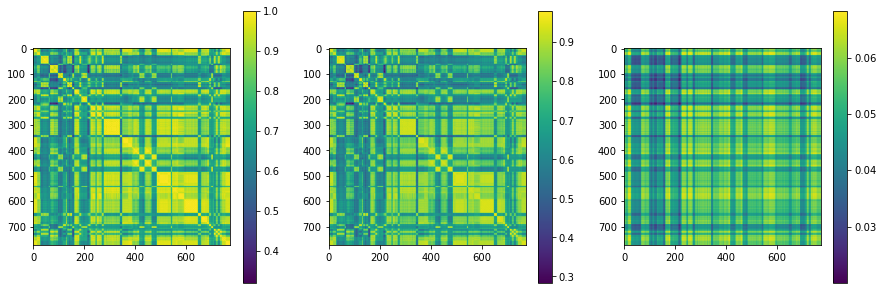

In [93]:
f, p = plt.subplots(1,3,figsize=(15,5))
p0 = p[0].imshow(hydrogen_kernel)
f.colorbar(p0,ax=p[0])
p1 = p[1].imshow(hydrogen_repr_kernel)
f.colorbar(p1,ax=p[1])
p2 = p[2].imshow(hydrogen_kernel - hydrogen_repr_kernel)
f.colorbar(p2,ax=p[2])

### Selecting sparse points

In [6]:
# Compute reduced (2238) training set feature matrices and sparsify them 
print("Computing feature matrices...")
start=time()
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)
manager_train = soap.transform(initial_train_set[:2238]) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  33.899149656295776 s


In [7]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 500
nc = 500
nn = 500
no = 500
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_opt = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  28.662877321243286 s


In [35]:
#Saving sparse points
dump_obj('raw_data/X_sparse_1pc_nsparse_500ps_FPS.json', X_sparse_opt)

In [15]:
#Load FPS-sorted sparse points
X_sparse_opt = load_obj('raw_data/X_sparse_1pc_nsparse_500ps_FPS.json')

### Compute kernel

In [18]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
zeta = 3
ntrain = 256 #choose number of structures to train on
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [9]:
#Compute kernel
start=time()
Knm = compute_KNM(initial_train_set[:ntrain], X_sparse_opt, kernel, soap)
print("Time taken: ", time()-start, "s")

Time taken:  495.86696600914 s


In [34]:
#Save kernel
np.save('raw_data/GAP_model_kernel', Knm)

In [16]:
#(Re)Load kernel
Knm = np.load('raw_data/GAP_model_kernel.npy')

### Train GAP model

In [54]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
model = train_gap_model(kernel, initial_train_set[:ntrain], Knm, X_sparse_opt, y_train_fps[:ntrain], y_dressed, 
                        grad_train=-get_forces(initial_train_set[:ntrain]), lambdas=[1e2,1e3], jitter=1e-9, 
                        solver = 'RKHS')

In [38]:
npred = 50 #choose number of predictions to make
yitp = []
fitp = []

for frm in tqdm(initial_train_set[:npred], desc = "Making predictions for initial training set...", leave=False):
    manager_val = soap.transform(frm)
    yitp.append(model.predict(manager_val))
    fitp.append(model.predict_forces(manager_val))

y_pred = np.array(yitp).flatten()
f_pred = np.concatenate(fitp)

Making predictions for initial training set...:   0%|          | 0/50 [00:00<?, ?it/s]

In [55]:
#predict energies and forces for validation set
npred=50
yvp = []
fvp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_val = soap.transform(frm)
    yvp.append(model.predict(manager_val))
    fvp.append(model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
#Make predictions in two batches to limit memory requirement
npred = 256 #choose number of predictions to make
start=time()
print('Making predictions for batch 1...')
y_pred_1 = predict_batched(initial_train_set[:int(npred/2)], ml_model = model)
print('Making predictions for batch 2...')
y_pred_2 = predict_batched(initial_train_set[int(npred/2):npred], ml_model = model)
print("Total time taken: ", time()-start, "s")
y_pred = np.append(y_pred_1, y_pred_2, axis=0)

Making predictions for batch 1...
Making predictions for batch 2...
Total time taken:  139.66037106513977 s


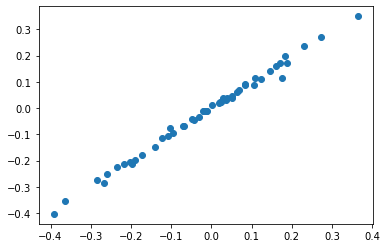

In [35]:
#Plot predictions
y_atoms = mlr.predict(X_train_fps[:npred])
plt.scatter((y_train_fps[:npred] - y_atoms[:npred])/np.sum(X_train_fps[:npred],axis=1),
            (y_pred[:npred] - y_atoms[:npred])/np.sum(X_train_fps[:npred],axis=1))

In [41]:
rmse_eval = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
print("RMSE validation:", rmse_eval)

RMSE validation: 0.05249232145360043


In [56]:
rmse_eval = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
print("RMSE validation:", rmse_eval)
print("Lambas: 100, 1000")

RMSE validation: 0.05950601409928219
Lambas: 100, 1000


In [53]:
rmse_eval = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
print("RMSE validation:", rmse_eval)
print("Lambas: 10, 100")

RMSE validation: 0.03398081076867194
Lambas: 10, 100


In [50]:
rmse_eval = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
print("RMSE validation:", rmse_eval)
print("Lambas: 1, 10")

RMSE validation: 0.03562384237876831
Lambas: KRR potential model


In [39]:
print("RMSE:", np.sqrt(np.mean((y_train_fps[:npred] - y_atoms[:npred])/np.sum(X_train_fps[:npred],axis=1) - (y_pred[:npred] - y_atoms[:npred])/np.sum(X_train_fps[:npred],axis=1))))

RMSE: 0.029428721005435848


## Optimise GAP model parameters
Optimise the regularisation and jitter constants for optimal GAP model RMSE


In [13]:
ntrain = 256 #choose number of structures to train on
npred = 100 #choose number of predictions to make
bsize = 100 #choose prediction batch size (to limit memory requirement)

y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

y_atoms = mlr.predict(X_train_fps[:npred]) #get dressed atom energies 

energy_regs = []; force_regs = []; errors = []; 
it = 1
for e_reg in np.logspace(-5, 0, 6): #iterate over energy regulariser
    for f_reg in np.logspace(-4, 1, 6): #iterate over force regulariser
        print('Iteration:', it, '/ 36')
        start = time()
        model = train_gap_model(kernel, initial_train_set[:ntrain], Knm, X_sparse_opt, y_train_fps[:ntrain], 
                                y_dressed, grad_train=-get_forces(initial_train_set[:ntrain]), 
                                lambdas=[e_reg,f_reg], jitter=1e-9, solver = 'RKHS') #create model
        ypred = []
        for batch in range(int(npred/bsize + 0.9999)): #make predictions in batches
            prediction = predict_batched(val_set[batch*bsize:(batch+1)*bsize], ml_model = model)
            ypred.extend(prediction)
        err = np.sqrt(np.mean(((y_val[:npred] - y_atoms[:npred])/np.sum(X_val[:npred],axis=1) - (ypred[:npred] - y_atoms[:npred])/np.sum(X_val[:npred],axis=1))**2))
        errors.append(err)
        energy_regs.append(e_reg)
        force_regs.append(f_reg)
        print(e_reg, f_reg, err)
        it += 1
        print('Time taken:', time()-start, 's')
print(energy_regs, force_regs, errors)

Iteration: 1 / 36
1e-05 0.0001 0.04430039938847339
Time taken: 67.57142901420593 s
Iteration: 2 / 36
1e-05 0.001 0.04307937209708902
Time taken: 67.26754593849182 s
Iteration: 3 / 36
1e-05 0.01 0.04307282315971346
Time taken: 69.21627712249756 s
Iteration: 4 / 36
1e-05 0.1 0.04306540982906824
Time taken: 68.41953039169312 s
Iteration: 5 / 36


/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/rascal/models/krr.py:121: LinAlgWarning: Ill-conditioned matrix (rcond=7.67631e-17): result may not be accurate.
  self._weights = self._PKPhi @ scipy.linalg.solve(


1e-05 1.0 0.04238638970076741
Time taken: 68.23008823394775 s
Iteration: 6 / 36


/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/rascal/models/krr.py:121: LinAlgWarning: Ill-conditioned matrix (rcond=8.96867e-18): result may not be accurate.
  self._weights = self._PKPhi @ scipy.linalg.solve(


1e-05 10.0 0.03446891470177998
Time taken: 67.58771586418152 s
Iteration: 7 / 36
0.0001 0.0001 0.06734785000383003
Time taken: 66.86583375930786 s
Iteration: 8 / 36
0.0001 0.001 0.04430039871991344
Time taken: 67.00007820129395 s
Iteration: 9 / 36
0.0001 0.01 0.04307929858317576
Time taken: 66.61387395858765 s
Iteration: 10 / 36
0.0001 0.1 0.043065473346597764
Time taken: 68.06631302833557 s
Iteration: 11 / 36
0.0001 1.0 0.0423868985082538
Time taken: 66.41185164451599 s
Iteration: 12 / 36
0.0001 10.0 0.034465595189632936
Time taken: 66.28696179389954 s
Iteration: 13 / 36
0.001 0.0001 0.38092274419996036
Time taken: 66.68498468399048 s
Iteration: 14 / 36
0.001 0.001 0.06734784980757445
Time taken: 66.583340883255 s
Iteration: 15 / 36
0.001 0.01 0.04430033186239765
Time taken: 67.11742925643921 s
Iteration: 16 / 36
0.001 0.1 0.043071953383643474
Time taken: 66.61653923988342 s
Iteration: 17 / 36
0.001 1.0 0.04238694730756491
Time taken: 66.53981828689575 s
Iteration: 18 / 36
0.001 10.0 

In [14]:
lambda_optimisation_results = np.asarray([energy_regs, force_regs, errors])
np.save('raw_data/lambda_optimisation_results', lambda_optimisation_results)

In [30]:
min_errs = np.argmin(lambda_optimisation_results[2])
print("Minimum error: ", lambda_optimisation_results[2][min_errs], ".", "Lambas for minimum error: ", 
     lambda_optimisation_results[0][min_errs], lambda_optimisation_results[1][min_errs])

Minimum error:  0.0344295263171315 . Lambas for minimum error:  0.1 10.0


In [17]:
ntrain = 256 #choose number of structures to train on
npred = 100 #choose number of predictions to make
bsize = 100 #choose prediction batch size (to limit memory requirement)

y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

y_atoms = mlr.predict(X_train_fps[:npred]) #get dressed atom energies 

energy_regs = []; force_regs = []; errors = []; 
it = 1
for e_reg in np.logspace(-1, 3, 5): #iterate over energy regulariser
    for f_reg in np.logspace(0, 4, 5): #iterate over force regulariser
        print('Iteration:', it, '/ 25')
        start = time()
        model = train_gap_model(kernel, initial_train_set[:ntrain], Knm, X_sparse_opt, y_train_fps[:ntrain], 
                                y_dressed, grad_train=-get_forces(initial_train_set[:ntrain]), 
                                lambdas=[e_reg,f_reg], jitter=1e-9, solver = 'RKHS') #create model
        ypred = []
        for batch in range(int(npred/bsize + 0.9999)): #make predictions in batches
            prediction = predict_batched(val_set[batch*bsize:(batch+1)*bsize], ml_model = model)
            ypred.extend(prediction)
        err = np.sqrt(np.mean(((y_val[:npred] - y_atoms[:npred])/np.sum(X_val[:npred],axis=1) - (ypred[:npred] - y_atoms[:npred])/np.sum(X_val[:npred],axis=1))**2))
        errors.append(err)
        energy_regs.append(e_reg)
        force_regs.append(f_reg)
        print(e_reg, f_reg, err)
        it += 1
        print('Time taken:', time()-start, 's')
print(energy_regs, force_regs, errors)

Iteration: 1 / 25
0.1 1.0 0.04367521643671826
Time taken: 68.55218315124512 s
Iteration: 2 / 25
0.1 10.0 0.0344295263171315
Time taken: 68.74697256088257 s
Iteration: 3 / 25
0.1 100.0 0.035733923147977305
Time taken: 68.52839636802673 s
Iteration: 4 / 25
0.1 1000.0 0.037105265759278
Time taken: 67.05772399902344 s
Iteration: 5 / 25
0.1 10000.0 0.03705772536327833
Time taken: 67.55786228179932 s
Iteration: 6 / 25
1.0 1.0 0.067180818185429
Time taken: 66.32911348342896 s
Iteration: 7 / 25
1.0 10.0 0.03639285780656519
Time taken: 65.9461898803711 s
Iteration: 8 / 25
1.0 100.0 0.033266533755695715
Time taken: 66.50592970848083 s
Iteration: 9 / 25
1.0 1000.0 0.03517318646655441
Time taken: 65.94753766059875 s
Iteration: 10 / 25
1.0 10000.0 0.03520315249423436
Time taken: 68.10739469528198 s
Iteration: 11 / 25
10.0 1.0 0.3920610074124877
Time taken: 66.25475692749023 s
Iteration: 12 / 25
10.0 10.0 0.06650745800632393
Time taken: 64.50493359565735 s
Iteration: 13 / 25
10.0 100.0 0.03455021559

In [18]:
lambda_optimisation_results_2 = np.asarray([energy_regs, force_regs, errors])
np.save('raw_data/lambda_optimisation_results_2', lambda_optimisation_results_2)

In [19]:
min_errs = np.argmin(lambda_optimisation_results_2[2])
print("Minimum error: ", lambda_optimisation_results_2[2][min_errs], ".", "Lambas for minimum error: ", 
     lambda_optimisation_results_2[0][min_errs], lambda_optimisation_results_2[1][min_errs])

Minimum error:  0.033266533755695715 . Lambas for minimum error:  1.0 100.0


Might be better to re-run this test using a larger X_sparse (that is calculated from the optimal number of PCovCUR structures computed..?), and by using a larger Kernel matrix based on the PCovCUR-sorted structures.
Furthermore, the error should really be tested on the validation set, rather than the training set. 
Note: you have to recompute the Kernel if you decide to use a larger number of training structures

Questions:

Are these optimisation results reliable for a larger train set? Optimal lambas for a smaller training set might be higher as the model needs to generalise more in order to obtain reliable results for the validation set....

How much RAM will I need to compute the larger Kernel for the optimal 8000 training configurations?

## PCovCUR Sample Selection
Implement a PCovCUR-style sample selection (instead of active-learning) in order to obtain the most relevant configurations for training the GAP model

In [5]:
#Redefine hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=False, #normalize after feature computation
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #compute forces now too
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [19]:
#Get feature vectors for training database
train_feat = get_features(train_set)

  0%|          | 0/23 [00:00<?, ?it/s]

In [52]:
#Save feature vectors
np.save('raw_data/CSD-10k_features_train_set_unnormalized', train_feat)

In [6]:
#Load feature vectors
train_feat = np.load('raw_data/CSD-10k_features_train_set_unnormalized.npy')

In [7]:
#Normalize and centre feature matrix
normalizer = StandardFlexibleScaler()
train_feat_norm = normalizer.fit_transform(train_feat)

In [8]:
#Get per-atom binding energies as property to regress
y_atoms = mlr.predict(X_train) #get baseline for training set
yred_train = (y_train - y_atoms)/np.sum(X_train,axis=1) #get per atom binding energies for training set

In [23]:
#Run PCovCUR filtering
selector = PCovCUR(mixing = 0.3, recompute_every =50, k = 1, tolerance = 1e-12, 
                   n_to_select = 100, progress_bar = True) #Choose params for PCovCUR feature selection
                #mixing parameter between 0.1 and 0.5 good to use when only learning one property (Rose said)
X_selected = []
y_currents = []
y_current_scores = [] 
y_current_squared_scores = []
start = time()
for inum, num in enumerate(range(100, len(train_feat_norm), 100)): #iterate every 50 samples
    print("Selecting up to", num, "samples.")
    if inum == 0:
        selector.n_to_select=num #choose number of samples to select
        filtered = selector.fit(train_feat_norm, yred_train) #cold start if selection hadn't been carried out yet
    else:
        filtered.n_to_select = num #choose number of samples to select
        filtered.fit(train_feat_norm, yred_train, warm_start=True)
    y_currents.append(filtered.y_current_)
    y_current_score = np.mean(filtered.y_current_)
    print("y_current MSE with", num, "samples selected:", np.mean(filtered.y_current_**2))
    print("")
    y_current_scores.append(y_current_score)
    y_current_squared_scores.append(filtered.y_current_**2)
    X_selected.append(filtered.X_selected_)

Selecting up to 100 samples.


  0%|          | 0/100 [00:00<?, ?it/s]

y_current MSE with 100 samples selected: 0.06783187613427867

Selecting up to 200 samples.


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
#Convert and save results
np.save('raw_data/CSD-10k_features_train_set_PCovCUR_X_selected', np.asarray(X_selected, dtype='object'))
np.save('raw_data/CSD-10k_features_train_set_PCovCUR_y_currents', np.asarray(y_currents))
np.save('raw_data/CSD-10k_features_train_set_PCovCUR_y_current_scores', np.asarray(y_current_scores))
np.save('raw_data/CSD-10k_features_train_set_PCovCUR_y_current_squared_scores', np.asarray(y_current_squared_scores))

In [7]:
#(Re-)load results
X_selected = np.load('raw_data/CSD-10k_features_train_set_PCovCUR_X_selected.npy', allow_pickle=True)
y_currents = np.load('raw_data/CSD-10k_features_train_set_PCovCUR_y_currents.npy')
y_current_scores = np.load('raw_data/CSD-10k_features_train_set_PCovCUR_y_current_scores.npy')
y_current_squared_scores = np.load('raw_data/CSD-10k_features_train_set_PCovCUR_y_current_squared_scores.npy')

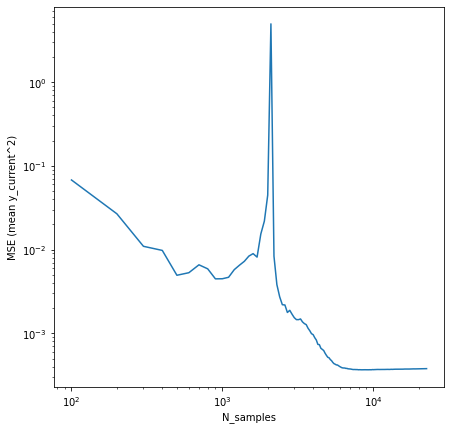

In [111]:
#Plot results
f,p = plt.subplots(figsize=(7,7))
p.plot(range(100, len(train_feat_norm), 100), np.mean(y_current_squared_scores, axis=1))
p.set_ylabel('MSE (mean y_current^2)')
p.set_yscale('log')
p.set_xlabel('N_samples')
p.set_xscale('log')

In [19]:
print("Optimal number of samples: ", range(100, len(train_feat_norm), 100)[np.argmin(np.mean(y_current_squared_scores, axis=1))])

Optimal number of samples:  8400


## Creating the full-size model

The final, full-size GAP model can now be created, as the necessary parameters have now been optimised, inclduing:
- SOAP hyperparameters
- Optimal sparse points
- Optimal number of training set configurations
- Regularization constants for the GAP model

### PCovCUR sample selection

In [4]:
#Run PCovCUR filtering on training set
selector = PCovCUR(mixing = 0.3, recompute_every =1, k = 1, tolerance = 1e-12, 
                   n_to_select = 1, progress_bar = True) #Choose params for PCovCUR feature selection
                #mixing parameter between 0.1 and 0.5 good to use when only learning one property (Rose said)

X_selected = []
y_currents = []
y_current_scores = [] 
y_current_squared_scores = []
start = time()

selector.n_to_select = 3000 #choose number of samples to select
filtered = selector.fit(train_feat_norm, yred_train) #cold start if selection hadn't been carried out yet

filtered.recompute_every = 10
filtered.n_to_select = 5000 #choose number of samples to select
filtered.fit(train_feat_norm, yred_train, warm_start=True)

filtered.recompute_every = 25  
filtered.n_to_select = 8400 #choose number of samples to select
filtered.fit(train_feat_norm, yred_train, warm_start=True)

y_currents.append(filtered.y_current_)
y_current_score = np.mean(filtered.y_current_)
print("y_current MSE with 8400 samples selected:", np.mean(filtered.y_current_**2))
print("")
y_current_scores.append(y_current_score)
y_current_squared_scores.append(filtered.y_current_**2)
X_selected.append(filtered.X_selected_)

TypeError: __init__() got an unexpected keyword argument 'recompute_every'

In [19]:
#Run PCovCUR filtering on training set
selector = PCovCUR(mixing = 0.3, k = 1, tolerance = 1e-12, #recompute_every = 1,
                   n_to_select = 1, progress_bar = True) #Choose params for PCovCUR feature selection
                #mixing parameter between 0.1 and 0.5 good to use when only learning one property (Rose said)

X_selected = []
y_currents = []
y_current_scores = [] 
y_current_squared_scores = []
start = time()

selector.n_to_select = 3000 #choose number of samples to select
filtered = selector.fit(train_feat_norm, yred_train) #cold start if selection hadn't been carried out yet

#filtered.recompute_every = 10
filtered.n_to_select = 5000 #choose number of samples to select
filtered.fit(train_feat_norm, yred_train, warm_start=True)

#filtered.recompute_every = 25  
filtered.n_to_select = 8400 #choose number of samples to select
filtered.fit(train_feat_norm, yred_train, warm_start=True)

y_currents.append(filtered.y_current_)
y_current_score = np.mean(filtered.y_current_)
print("y_current MSE with 8400 samples selected:", np.mean(filtered.y_current_**2))
print("")
y_current_scores.append(y_current_score)
y_current_squared_scores.append(filtered.y_current_**2)
X_selected.append(filtered.X_selected_)


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/skcosmo/utils/_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.")


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/skcosmo/utils/_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.")


  0%|          | 0/3400 [00:00<?, ?it/s]

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/skcosmo/utils/_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.")


y_current MSE with 8400 samples selected: 0.00037198387927045846



In [20]:
with open('raw_data/selector.pkl', 'wb') as f:
    pickle.dump(filtered, f)

In [29]:
#Create new dataset of PCovCUR-selected configurations (Atoms objects)
chosen_feats = filtered.X_selected_.copy()
train_set_CUR = []
for chosen in tqdm(chosen_feats):
    for ifeat, feat in enumerate(train_feat_norm):
        if np.array_equal(chosen, feat) == True:
            train_set_CUR.append(train_set[ifeat])

  0%|          | 0/8400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
np.save('model_data/train_set_CUR', np.asarray(train_set_CUR, dtype='object')) #save PCovCUR odered training set

In [5]:
train_set_CUR = np.load('model_data/train_set_CUR.npy', allow_pickle=True)

In [7]:
#Get training data for the CUR-sorted training set
ytC = []
for ifrm, frm in enumerate(train_set_CUR):
    ytC.append(frm.info['energy'])
ytrain_CUR = np.array(ytC)

In [6]:
uniques = []
for ifrm, frm in enumerate(train_set_CUR):
    if frm.get_volume() not in uniques:
        uniques.append(frm.get_volume())
print(len(uniques))

2088


### Selecting sparse points

In [4]:
#Redefine hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [8]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_CUR) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  151.98670148849487 s


In [9]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  369.27039074897766 s


In [10]:
dump_obj('model_data/X_sparse.json', X_sparse)

In [6]:
X_sparse = load_obj('model_data/X_sparse.json')

### Compute kernel

In [10]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [12]:
#Compute kernel
start=time()
Knm = compute_KNM(tqdm(train_set_CUR, desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

compute KNM:   0%|          | 0/8400 [00:00<?, ?it/s]

Time taken:  105517.32448196411 s


In [13]:
#Save kernel
np.save('model_data/Knm_kernel', Knm)

In [8]:
Knm = np.load('model_data/Knm_kernel.npy')

### Train GAP model

In [47]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_CUR, Knm, X_sparse, ytrain_CUR, y_dressed, 
                        grad_train=-get_forces(train_set_CUR), lambdas=[0.1,1], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 200.60232281684875


In [48]:
dump_obj('model_data/full_GAP_model_0.1_1.json', full_model)

In [5]:
full_model = load_obj('model_data/full_GAP_model.json')

In [27]:
full_model.predict_forces_with_gradient_kernel

<bound method KRR.get_representation_calculator of <rascal.models.krr.KRR object at 0x7f5ae186a220>>

### Predict on validation set
This takes a while, and must be done in batches to limit the memory requirement. Please load predictions below, if the sole purpose is analysing results.

In [ ]:
#Get true energies and forces for validation set
yvt = []
fvt = []

for frm in val_set:
    yvt.append(frm.info['energy'])
    fvt.append(frm.get_array('forces'))

yval_true = np.array(yvt)
fval_true = np.concatenate(fvt)

In [50]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

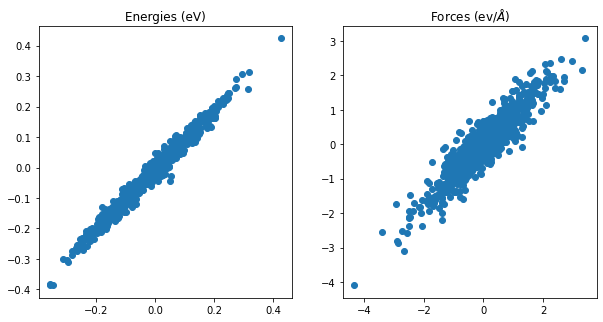

In [51]:
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [52]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [53]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [46]:
print(rmse_energy, rmse_forces) #0.1, 1 lambas

0.017455935846640746 0.3505799526367856


Lowest collective RMSE for energies and forces (using 1 x energy RMSE + 5 x force RMSE) came from using lambdas of 0.1 and 1 for energies and forces, respectively. Those will therefore be used for the final model

#### Save and (re)load predictions

In [47]:
#Save predictions
np.save('raw_data/GAP_model_ypred_val', ypred_val)

In [26]:
#(Re)load predictions
ypred_val = np.load('raw_data/GAP_model_ypred_val.npy')

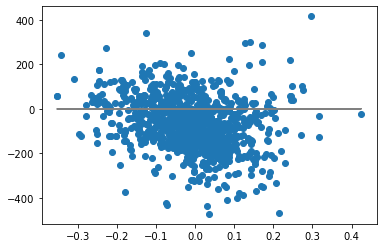

In [106]:
f,p = plt.subplots(1,1)
p.plot(yred_val,yred_val,c='grey')
p.scatter(yred_val,(ypred_val - mlr.predict(X_val))/np.sum(X_val,axis=1))
#p.set_aspect(1)